In [1]:
import os
import numpy as np
import time
import librosa
import pyworld
import matplotlib.pyplot as plt

In [2]:
def load_wavs(wav_dir, sr):
    
    debug_num = 0
    wavs = list()
    for file in os.listdir(wav_dir):
        debug_num += 1
        if (debug_num > 100):
            break
        file_path = os.path.join(wav_dir, file)
        wav, _ = librosa.load(file_path, sr = sr, mono = True)
        #wav = wav.astype(np.float64)
        wavs.append(wav)

    return wavs

def world_decompose(wav, fs, frame_period = 5.0):

    # Decompose speech signal into f0, spectral envelope and aperiodicity using WORLD
    wav = wav.astype(np.float64)
    f0, timeaxis = pyworld.harvest(wav, fs, frame_period = frame_period, f0_floor = 71.0, f0_ceil = 800.0)
    sp = pyworld.cheaptrick(wav, f0, timeaxis, fs)
    ap = pyworld.d4c(wav, f0, timeaxis, fs)

    return f0, timeaxis, sp, ap

def world_encode_spectral_envelop(sp, fs, dim = 24):

    # Get Mel-cepstral coefficients (MCEPs)

    #sp = sp.astype(np.float64)
    coded_sp = pyworld.code_spectral_envelope(sp, fs, dim)

    return coded_sp

def world_decode_spectral_envelop(coded_sp, fs):

    fftlen = pyworld.get_cheaptrick_fft_size(fs)
    #coded_sp = coded_sp.astype(np.float32)
    #coded_sp = np.ascontiguousarray(coded_sp)
    decoded_sp = pyworld.decode_spectral_envelope(coded_sp, fs, fftlen)

    return decoded_sp


def world_decode_data(coded_sps, fs):

    decoded_sps =  list()

    for coded_sp in coded_sps:
        decoded_sp = world_decode_spectral_envelop(coded_sp, fs)
        decoded_sps.append(decoded_sp)

    return decoded_sps


def world_speech_synthesis(f0, decoded_sp, ap, fs, frame_period):

    #decoded_sp = decoded_sp.astype(np.float64)
    wav = pyworld.synthesize(f0, decoded_sp, ap, fs, frame_period)
    # Librosa could not save wav if not doing so
    wav = wav.astype(np.float32)

    return wav

def coded_sps_normalization_fit_transoform(coded_sps):

    coded_sps_concatenated = np.concatenate(coded_sps, axis = 1)
    coded_sps_mean = np.mean(coded_sps_concatenated, axis = 1, keepdims = True)
    coded_sps_std = np.std(coded_sps_concatenated, axis = 1, keepdims = True)

    coded_sps_normalized = list()
    for coded_sp in coded_sps:
        coded_sps_normalized.append((coded_sp - coded_sps_mean) / coded_sps_std)
    
    return coded_sps_normalized, coded_sps_mean, coded_sps_std

def coded_sps_normalization_transoform(coded_sps, coded_sps_mean, coded_sps_std):

    coded_sps_normalized = list()
    for coded_sp in coded_sps:
        coded_sps_normalized.append((coded_sp - coded_sps_mean) / coded_sps_std)
    
    return coded_sps_normalized

def coded_sps_normalization_inverse_transoform(normalized_coded_sps, coded_sps_mean, coded_sps_std):

    coded_sps = list()
    for normalized_coded_sp in normalized_coded_sps:
        coded_sps.append(normalized_coded_sp * coded_sps_std + coded_sps_mean)

    return coded_sps

def coded_sp_padding(coded_sp, multiple = 4):

    num_features = coded_sp.shape[0]
    num_frames = coded_sp.shape[1]
    num_frames_padded = int(np.ceil(num_frames / multiple)) * multiple
    num_frames_diff = num_frames_padded - num_frames
    num_pad_left = num_frames_diff // 2
    num_pad_right = num_frames_diff - num_pad_left
    coded_sp_padded = np.pad(coded_sp, ((0, 0), (num_pad_left, num_pad_right)), 'constant', constant_values = 0)

    return coded_sp_padded

def wav_padding(wav, sr, frame_period, multiple = 4):

    assert wav.ndim == 1 
    num_frames = len(wav)
    num_frames_padded = int((np.ceil((np.floor(num_frames / (sr *  frame_period / 1000)) + 1) / multiple + 1) * multiple - 1) * (sr * frame_period / 1000))
    num_frames_diff = num_frames_padded - num_frames
    num_pad_left = num_frames_diff // 2
    num_pad_right = num_frames_diff - num_pad_left
    wav_padded = np.pad(wav, (num_pad_left, num_pad_right), 'constant', constant_values = 0)

    return wav_padded

def logf0_statistics(f0s):

    log_f0s_concatenated = np.ma.log(np.concatenate(f0s))
    log_f0s_mean = log_f0s_concatenated.mean()
    log_f0s_std = log_f0s_concatenated.std()

    return log_f0s_mean, log_f0s_std

def pitch_conversion(f0, mean_log_src, std_log_src, mean_log_target, std_log_target):

    # Logarithm Gaussian normalization for Pitch Conversions
    f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)

    return f0_converted

def wavs_to_specs(wavs, n_fft = 1024, hop_length = None):

    stfts = list()
    for wav in wavs:
        stft = librosa.stft(wav, n_fft = n_fft, hop_length = hop_length)
        stfts.append(stft)

    return stfts


def wavs_to_mfccs(wavs, sr, n_fft = 1024, hop_length = None, n_mels = 128, n_mfcc = 24):

    mfccs = list()
    for wav in wavs:
        mfcc = librosa.feature.mfcc(y = wav, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels, n_mfcc = n_mfcc)
        mfccs.append(mfcc)

    return mfccs

def mfccs_normalization(mfccs):

    mfccs_concatenated = np.concatenate(mfccs, axis = 1)
    mfccs_mean = np.mean(mfccs_concatenated, axis = 1, keepdims = True)
    mfccs_std = np.std(mfccs_concatenated, axis = 1, keepdims = True)

    mfccs_normalized = list()
    for mfcc in mfccs:
        mfccs_normalized.append((mfcc - mfccs_mean) / mfccs_std)
    
    return mfccs_normalized, mfccs_mean, mfccs_std


In [3]:
def encode(filepath):
    
    wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
    wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
    f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
    coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
    coded_sp_transposed = coded_sp.T
    mcep_mean = np.mean(coded_sp_transposed)
    mcep_std = np.std(coded_sp_transposed)
    coded_sp_norm = (coded_sp_transposed - mcep_mean) / mcep_std
    
    return coded_sp_norm, mcep_mean, mcep_std, f0, ap


In [4]:
def decode(filepath, coded_sp_norm, mcep_mean, mcep_std, f0, ap):
        
        coded_sp = coded_sp_norm * mcep_std + mcep_mean
        coded_sp = coded_sp.T
        coded_sp = np.ascontiguousarray(coded_sp)
        decoded_sp = world_decode_spectral_envelop(coded_sp = coded_sp, fs = sampling_rate)
        wav_transformed = world_speech_synthesis(f0 = f0, decoded_sp = decoded_sp, ap = ap, fs = sampling_rate, frame_period = frame_period)
        librosa.output.write_wav(filepath, wav_transformed, sampling_rate)

In [75]:
data_dir =  './localcache/input'
output_dir = './localcache/output'

sampling_rate = 16000
num_mcep =32
frame_period = 10
n_frames = 128

In [76]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for file in os.listdir(data_dir):
    coded_sp_norm, mcep_mean, mcep_std, f0, ap = encode(os.path.join(data_dir, file))
    decode(os.path.join(output_dir, file), coded_sp_norm, mcep_mean, mcep_std, f0, ap)

In [71]:
coded_sp_norm, mcep_mean, mcep_std, f0, ap = encode(os.path.join(data_dir, "100001.wav"))

In [73]:
coded_sp_norm.shape
#mcep_mean.shape
#mcep_std

#f0.shape
#ap.shape

(32, 35203)

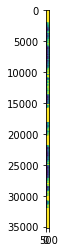

In [74]:
plt.imshow(ap)
#plt.plot(f0)